# Visualize Networkss

In [1]:
# Mathematical and Data Managment
import numpy as np
import pandas as pd
import scipy.sparse as sp

# Graph Managment
import graph_tool.all as gt
import networkx as nx
#from Code.utils.Functions import *
#from Code.utils.Segregation import *

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from fa2_visualization.forceatlas2 import ForceAtlas2

# Miscellaneous
from glob import glob
from tqdm import tqdm
import random
import time

random.seed(2)

# Create ForceAtlas2 object with desired parameters
forceatlas2 = ForceAtlas2(
                          # Behavior alternatives
                          outboundAttractionDistribution=True,  # Dissuade hubs
                          linLogMode=False,  # NOT IMPLEMENTED
                          adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                          edgeWeightInfluence=1.0,

                          # Performance
                          jitterTolerance=1.0,  # Tolerance
                          barnesHutOptimize=True,
                          barnesHutTheta=1.2,
                          multiThreaded=False,  # NOT IMPLEMENTED

                          # Tuning
                          scalingRatio=2.0,
                          strongGravityMode=False,
                          gravity=1.0,

                          # Log
                          verbose=True)

/mnt/disk2/anaconda3/envs/gt_global/lib/python3.11/site-packages/graph_tool/draw/cairo_draw.py:1544: RuntimeWarning: Error importing Gtk module: ; GTK+ drawing will not work.
  warnings.warn(msg, RuntimeWarning)


<class 'forceatlas2.ForceAtlas2'>


In [43]:
def to_networkx(g: gt.Graph) -> nx.Graph:
    if g.is_directed():
        nx_graph = nx.DiGraph()
    else:
        nx_graph = nx.Graph()

    # Add nodes with their properties to the NetworkX graph
    for v in g.vertices():
        node_properties = {prop_name: g.vp[prop_name][v] for prop_name in g.vp}
        nx_graph.add_node(int(v), **node_properties)

    # Add edges with their properties to the NetworkX graph
    for e in g.edges():
        edge_properties = {prop_name: g.ep[prop_name][e] for prop_name in g.ep}
        nx_graph.add_edge(int(e.source()), int(e.target()), **edge_properties)
    
    return nx_graph

In [44]:
# Load the graph
test_file = "/mnt/disk2/Data/3_Day_Graphs/starting_2021-05-03.graphml"

# Load Grap
g = gt.load_graph(test_file)
g.set_directed(False)
g_nx = to_networkx(g)

date = test_file.split('.')[-2].split('/')[-1]

In [64]:
# Create a list of nodes with degree less than 1
isolated_nodes = [node for node, degree in g_nx.degree() if degree <= 1]

# Remove these nodes from the graph
for node in isolated_nodes:
    g_nx.remove_node(node)

# Now g_nx has no nodes with

In [66]:
# Color
color_map_dict = {
    'No Retweets': 'gray',
    'Izquierda': 'blue',
    'Derecha': 'red',
    'Centro': 'green'
}
color_map = [color_map_dict[g_nx.nodes[node]['Political Label']] for node in g_nx]

In [67]:
# Size
node_degrees = [g_nx.degree(node) * 100 for node in g_nx.nodes()]
def normalize(x, max, min):
    return 100 * ((x - min)/(max - min))
max_deg = max(node_degrees)
min_deg = min(node_degrees)
node_size = list(map(lambda x: normalize(x, max_deg, min_deg), node_degrees))

In [68]:
layout = forceatlas2.forceatlas2_networkx_layout(g_nx, pos=None, iterations=1000)

100%|██████████| 1000/1000 [14:47<00:00,  1.13it/s]

BarnesHut Approximation  took  364.15  seconds
Repulsion forces  took  498.77  seconds
Gravitational forces  took  0.31  seconds
Attraction forces  took  17.57  seconds
AdjustSpeedAndApplyForces step  took  0.60  seconds


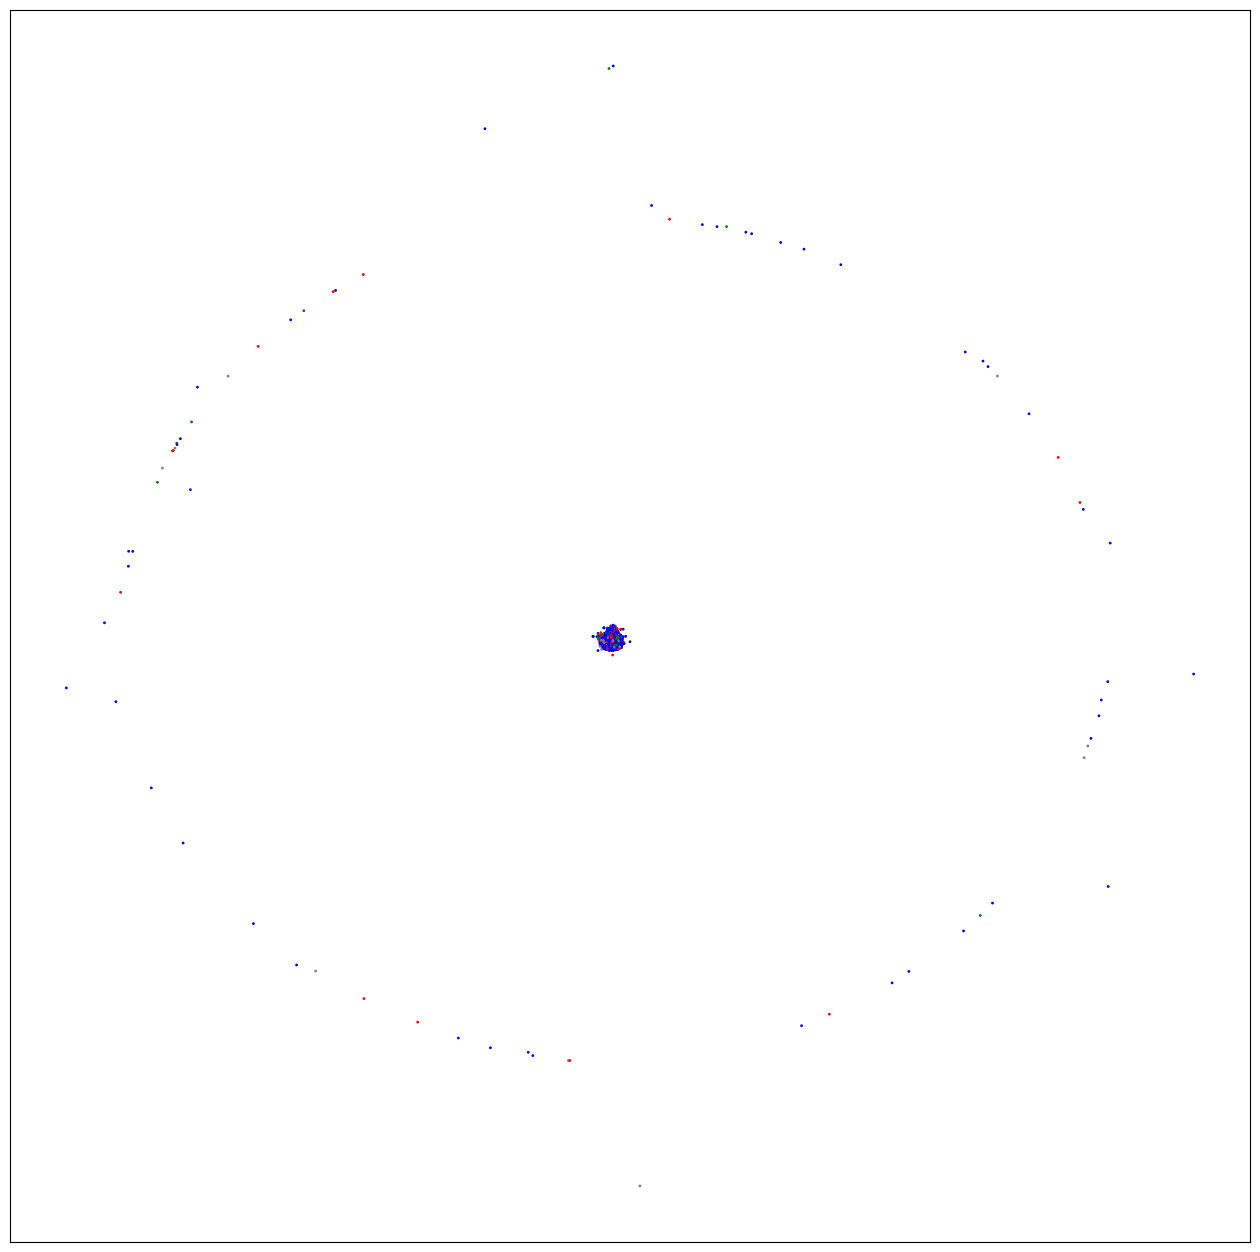

In [72]:
fig, ax = plt.subplots(figsize = (16,16))

nx.draw_networkx_nodes(g_nx, layout, node_color=color_map, node_size= 1, ax = ax)
plt.show()

In [6]:
ls = []
files = glob('/mnt/disk2/Data/Daily_graphs/*.graphml')

for file in files:
    g = gt.load_graph(file)
    N = g.num_vertices()
    ls.append((file,N))

sorted_ls = sorted(ls, key=lambda x: x[1], reverse=True)
sorted_files = [g[0] for g in sorted_ls]

In [ ]:
times = []
for idx, file in tqdm(enumerate(sorted_files)):
    
    start_time = time.time()
    
    g = gt.load_graph(file)
    g_nx = to_networkx(g)
    date = file.split('.')[-2].split('/')[-1]
    
    # Node Size
    node_in_degree = [g_nx.in_degree(node) for node in g_nx.nodes]

    # For Layout Algorythim, calculate it as undirected
    g_nx_undir = g_nx.to_undirected()
    
    # Initalizice Layout
    if idx == 0:

        # Apply ForceAtlas2 layout algorithm First time
        layout = forceatlas2_networkx_layout(g_nx_undir, pos, niter=30)
        print('First Layout')
    
    else:

        # Apply ForceAtlas2 layout algorithm
        layout = forceatlas2_networkx_layout(g_nx_undir, pos, niter=15)
    
    # Re assign new map
    for key in layout:
        if key in pos:
            pos[key] = layout[key]
    
    # Draw the network using matplotlib
    nx.draw_networkx_nodes(g_nx_undir, layout, node_color=colors,
                                    node_size = node_in_degree,
                                    edgecolors=(0,0,0,0.1))

    # Display the plot
    plt.savefig(f'../{date}_FA2_viz.png') 
    
    if idx%10 == 0:
        print(f'Grafo número {idx}')
    else:
        pass
    
    end_time = time.time()
    t = end_time - start_time
    times.append(t)